## Neural translation model - English to German Translation using seq2seq model

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

##Data import

Dataset downlad link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q


In [2]:
# load the dataset
NUM_EXAMPLES = 20000
data_examples = []
with open('./deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [3]:
# Preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()


## Text preprocessing

In [4]:
# separates list of english and german sentences and preprosess them
def get_sentence(data_examples):
    english_sentence = []
    german_sentence = []
    for line in data_examples:
        temp_list = line.strip().split('\t')
        english_sentence.append(preprocess_sentence(temp_list[0]))
        german_sentence.append(preprocess_sentence(temp_list[1]))
    return english_sentence, german_sentence

english_sentences, german_sentences = get_sentence(data_examples)

In [5]:
# Add a special "<start>" and "<end>" token to the beginning and end of every German sentence.
def add_start_and_end_token(german_sentences):
    start_token = '<start> '
    end_token = ' <end>'
    return [start_token + line + end_token for line in german_sentences]

german_sentences_with_token = add_start_and_end_token(german_sentences)

In [6]:
# tokenize the German sentences
def get_tokenizer(sentences):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    return tokenizer
german_tokenizer = get_tokenizer(german_sentences_with_token)
german_tokenizer_max_index = max(german_tokenizer.index_word.keys())
german_seq = german_tokenizer.texts_to_sequences(german_sentences_with_token)

In [7]:
# 5 randomly chosen examples of (preprocessed) English and German sentence pairs.
idx = tf.random.uniform((5,), minval=0, maxval=len(german_seq), dtype=tf.int32).numpy()
for i, id in enumerate(idx):
    if i != 0:
        print('\n==================================================================================\n')

    print(f'English translation: {english_sentences[id]}')
    print(f'German translation: {german_sentences_with_token[id]}')
    print(f'German tokenized sequence: {german_seq[id]}')

English translation: throw the dice .
German translation: <start> wuerfele ! <end>
German tokenized sequence: [1, 2598, 9, 2]


English translation: beat it .
German translation: <start> geh weg ! <end>
German tokenized sequence: [1, 89, 102, 9, 2]


English translation: i want to win .
German translation: <start> ich will gewinnen . <end>
German tokenized sequence: [1, 4, 66, 227, 3, 2]


English translation: i understand tom .
German translation: <start> ich verstehe tom . <end>
German tokenized sequence: [1, 4, 336, 5, 3, 2]


English translation: what a funny man !
German translation: <start> was fuer ein lustiger mann ! <end>
German tokenized sequence: [1, 38, 77, 19, 5374, 193, 9, 2]


In [8]:
# Pads the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.
german_padded_seq = tf.keras.preprocessing.sequence.pad_sequences(german_seq, padding='post')
print(f'german_padded_seq.shape = {german_padded_seq.shape}')

german_padded_seq.shape = (20000, 14)


##Data preparation

In [9]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [10]:
# Test the layer
embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape[0]

7

In [11]:
# Creates a random training and validation set split of the data, reserving 20% of the data for validation
from sklearn.model_selection import train_test_split

split = train_test_split(english_sentences, german_padded_seq, test_size=0.2, random_state=5)
english_sentences_train, english_sentences_test = split[:2]
german_padded_seq_train, german_padded_seq_test = split[2:]

In [12]:
# Loads the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
training_dataset = tf.data.Dataset.from_tensor_slices((english_sentences_train, german_padded_seq_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((english_sentences_test, german_padded_seq_test))

In [13]:
# function to map over the datasets that splits each English sentence at spaces.
def split_english_sentences(dataset):
    def func(english_sentence, german_padded_seq):
        return tf.strings.split(english_sentence), german_padded_seq
    dataset = dataset.map(func)
    return dataset
    
training_dataset = split_english_sentences(training_dataset)
validation_dataset = split_english_sentences(validation_dataset)

In [14]:
# function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model.
def embed_english_words(dataset, embedding_layer):
    dataset = dataset.map(lambda x,y: (embedding_layer(x), y))
    return dataset
    
training_dataset = embed_english_words(training_dataset, embedding_layer)
validation_dataset = embed_english_words(validation_dataset, embedding_layer)

In [15]:
# function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length. 
def filter_english_seq(dataset):
    dataset = dataset.filter(lambda x,y: len(x) <= 13)
    return dataset
  
training_dataset = filter_english_seq(training_dataset)
validation_dataset = filter_english_seq(validation_dataset)

In [16]:
# function to map over the datasets that pads each English sequence of embeddings with 
# some distinct padding value before the sequence, so that each sequence is length 13.
def pad_english_seq(dataset):
    def func(x, y):
        x = tf.pad(x, paddings=[[13 - tf.shape(x)[0], 0],[0,0]], constant_values=0)
        return x,y
    dataset = dataset.map(func)
    return dataset

training_dataset = pad_english_seq(training_dataset)
validation_dataset = pad_english_seq(validation_dataset)

In [17]:
# Batches both training and validation Datasets with a batch size of 16
def get_batched_dataset(dataset, training=False, batch_size=16):
    if training:
      dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    return dataset
training_batched_dataset = get_batched_dataset(training_dataset, training=True)
validation_batched_dataset = get_batched_dataset(validation_dataset)

In [18]:
# element_spec property for the training and validation Dataset
print(f'training_batched_dataset.element_spec = {training_batched_dataset.element_spec}')
print(f'validation_batched_dataset.element_spec = {validation_batched_dataset.element_spec}')

training_batched_dataset.element_spec = (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
validation_batched_dataset.element_spec = (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [19]:
english_batch, german_batch = next(iter(training_batched_dataset.take(1)))

In [20]:
# shape of the English data example from the training Dataset.
print(f'shape of the English data example = {english_batch.shape}')

shape of the English data example = (16, 13, 128)


In [21]:
# German data example Tensor from the validation Dataset.
print(f'shape of the German data example = \n{german_batch}')

shape of the German data example = 
[[   1    5    6   19 1837    3    2    0    0    0    0    0    0    0]
 [   1 1306  477   25    5    3    2    0    0    0    0    0    0    0]
 [   1    4   15  660    3    2    0    0    0    0    0    0    0    0]
 [   1    4   15 1361    3    2    0    0    0    0    0    0    0    0]
 [   1   11    6   19 4012  107    3    2    0    0    0    0    0    0]
 [   1    5   51  951    3    2    0    0    0    0    0    0    0    0]
 [   1    4  336   11   12    3    2    0    0    0    0    0    0    0]
 [   1    4   51   11  112    3    2    0    0    0    0    0    0    0]
 [   1  140   27   10  487    7    2    0    0    0    0    0    0    0]
 [   1    4 1043   53 1705    3    2    0    0    0    0    0    0    0]
 [   1    8  114  249   41    3    2    0    0    0    0    0    0    0]
 [   1   14    6 2863    3    2    0    0    0    0    0    0    0    0]
 [   1    4   30   33   62   12  102    3    2    0    0    0    0    0]
 [   1  746 307

## Custom layer


In [22]:
# layer that takes a batch of English data examples from one of the 
# Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
class EndTokenEmbeddingLayer(tf.keras.layers.Layer):
  
    def __init__(self, **kwargs):
        super(EndTokenEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        initializer = tf.random_normal_initializer()
        self.embedding = tf.Variable(initial_value=initializer(shape=(input_shape[-1],)))

    def call(self, input):
        x = tf.map_fn(lambda x: tf.concat([x, tf.reshape(tf.convert_to_tensor(self.embedding), (1,-1))], axis=0), input)
        return x

In [23]:
english_batch, german_batch = next(iter(training_batched_dataset.take(1)))
print(f'shape after passing through EndTokenEmbeddingLayer = {EndTokenEmbeddingLayer()(english_batch).shape}')

shape after passing through EndTokenEmbeddingLayer = (16, 14, 128)


## Encoder network

In [24]:
def get_encoder(input_shape):

    model_input = tf.keras.Input(shape=input_shape, name='input')
    x = EndTokenEmbeddingLayer(name='end_token_embedding_layer')(model_input)
    x = tf.keras.layers.Masking(name='masking_layer')(x)
    output, hidden_state, cell_state = tf.keras.layers.LSTM(512, return_state=True, name='lstm')(x)
    model = tf.keras.models.Model(inputs=model_input, outputs=[hidden_state, cell_state], name='Encoder')
    return model

In [25]:
encoder = get_encoder((None, 128))

english_batch, german_batch = next(iter(training_batched_dataset.take(1)))

hidden_state, cell_state = encoder(english_batch)

print(f'hidden_state shape: {hidden_state.shape}')
print(f'cell_state shape: {cell_state.shape}')

hidden_state shape: (16, 512)
cell_state shape: (16, 512)


In [26]:
# model summary for the encoder network.
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 128)]       0         
_________________________________________________________________
end_token_embedding_layer (E (None, None, 128)         128       
_________________________________________________________________
masking_layer (Masking)      (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


##Decoder network

In [27]:
class Decoder(tf.keras.models.Model):

    def __init__(self, german_tokenizer_max_index,**kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(german_tokenizer_max_index + 1, 128, mask_zero=True, name='embedding')
        self.lstm = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True, name='lstm')
        self.dense = tf.keras.layers.Dense(german_tokenizer_max_index + 1, name='dense')
        
    def call(self, inputs, hidden_state, cell_state):
        x = self.embedding(inputs)
        x = self.lstm(x, initial_state=[hidden_state, cell_state])
        return self.dense(x[0]), x[1], x[2]

In [28]:
english_batch, german_batch = next(iter(training_batched_dataset.take(1)))

encoder = get_encoder((None, 128))
hidden_state, cell_state = encoder(english_batch)

decoder = Decoder(german_tokenizer_max_index, name='Decoder')
output, hidden_state, cell_state = decoder(german_batch, hidden_state, cell_state)

print(f'output shape: {output.shape}')
print(f'hidden_state shape: {hidden_state.shape}')
print(f'cell_state shape: {cell_state.shape}')

output shape: (16, 14, 5744)
hidden_state shape: (16, 512)
cell_state shape: (16, 512)


In [29]:
# model summary for the decoder network
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm (LSTM)                  multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## Training

In [30]:
# function that takes a Tensor batch of German data (as extracted from the 
# training Dataset), and returns a tuple containing German inputs and outputs for the decoder model

def get_german_data(batch_data):
    return batch_data[:,:-1], batch_data[:,1:]

In [31]:
# computes the forward and backward pass for your translation model.

@tf.function
def propogate(english_input, german_input, german_output, encoder, decoder, loss_fn):

    with tf.GradientTape() as tape:
      encoder_hidden_state, encoder_cell_state = encoder(english_input)
      decoder_return_sequence, _, _ = decoder(german_input, encoder_hidden_state, encoder_cell_state)      
      loss = loss_fn(german_output, decoder_return_sequence)
    return loss, tape.gradient(loss, [encoder.trainable_variables, decoder.trainable_variables])

In [32]:
# custom training loop

def train(encoder, decoder, num_epochs, training_batched_dataset, validation_batched_dataset, patience):

    training_epochs_losses = []
    validation_epochs_losses = []

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    patience_count = 0
    for i in range(num_epochs):
        
        training_epoch_loss_avg = tf.keras.metrics.Mean()
        validation_epoch_loss_avg = tf.keras.metrics.Mean()

        for english, german in training_batched_dataset.as_numpy_iterator():

            german_input, german_output = get_german_data(german)
            loss, [encoder_gradient, decoder_gradient] = propogate(english, german_input, german_output, encoder, decoder, loss_fn)
            training_epoch_loss_avg(loss)
            optimizer.apply_gradients(zip(encoder_gradient, encoder.trainable_variables))
            optimizer.apply_gradients(zip(decoder_gradient, decoder.trainable_variables))

        for english, german in validation_batched_dataset:

            german_input, german_output = get_german_data(german)
            encoder_hidden_state, encoder_cell_state = encoder(english)
            decoder_return_sequence, _, _ = decoder(german_input, encoder_hidden_state, encoder_cell_state)
            validation_epoch_loss_avg(loss_fn(german_output, decoder_return_sequence))


        validation_epoch_loss = validation_epoch_loss_avg.result().numpy()

        if not validation_epochs_losses or validation_epoch_loss < min(validation_epochs_losses):
            print('saving best weights')
            encoder.save_weights('./encoder/checkpoint')
            decoder.save_weights('./decoder/checkpoint')

        if validation_epochs_losses and validation_epoch_loss > min(validation_epochs_losses):
            patience_count += 1
        else:
            patience_count = 0

        if patience_count > patience:
            break

        validation_epochs_losses.append(validation_epoch_loss)

        training_epoch_loss = training_epoch_loss_avg.result().numpy()
        training_epochs_losses.append(training_epoch_loss)
        

        print(f'epoch: {i+1}/{num_epochs}, loss: {str(round(training_epoch_loss, 2))}, val_loss: {str(round(validation_epoch_loss, 2))}')
        if patience_count > patience:
            break
    
    return training_epochs_losses, validation_epochs_losses

In [33]:
encoder = get_encoder(input_shape=(None, 128))
decoder = Decoder(german_tokenizer_max_index)
num_epochs = 15
patience = 1

training_batched_dataset = get_batched_dataset(training_dataset, training=True)
validation_batched_dataset = get_batched_dataset(validation_dataset)

training_epochs_losses, validation_epoch_losses = train(encoder, decoder, num_epochs, training_batched_dataset, validation_batched_dataset, patience)

saving best weights
epoch: 1/15, loss: 5.32, val_loss: 4.59
saving best weights
epoch: 2/15, loss: 4.02, val_loss: 3.68
saving best weights
epoch: 3/15, loss: 3.09, val_loss: 2.93
saving best weights
epoch: 4/15, loss: 2.28, val_loss: 2.27
saving best weights
epoch: 5/15, loss: 1.57, val_loss: 1.73
saving best weights
epoch: 6/15, loss: 1.02, val_loss: 1.37
saving best weights
epoch: 7/15, loss: 0.66, val_loss: 1.17
saving best weights
epoch: 8/15, loss: 0.45, val_loss: 1.07
saving best weights
epoch: 9/15, loss: 0.33, val_loss: 1.02
saving best weights
epoch: 10/15, loss: 0.25, val_loss: 1.01
saving best weights
epoch: 11/15, loss: 0.2, val_loss: 1.0
epoch: 12/15, loss: 0.16, val_loss: 1.01


In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

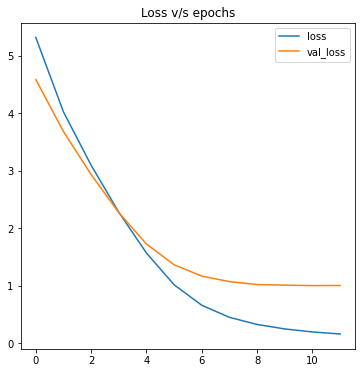

In [35]:
# loss vs epoch for both training and validation sets.
plt.figure(figsize=(6,6))
plt.plot(training_epochs_losses)
plt.plot(validation_epoch_losses)
plt.legend(['loss', 'val_loss'])
plt.title('Loss v/s epochs');

##Load best weights

In [36]:
decoder = Decoder(german_tokenizer_max_index, name='Decoder')
decoder.load_weights('./decoder/checkpoint')

encoder = get_encoder((None, 128))
encoder.load_weights('./encoder/checkpoint')

##Evaluate Model

In [37]:
english_sentences, german_sentences = get_sentence(data_examples)

split = train_test_split(english_sentences, german_sentences, test_size=0.2, random_state=5)
_ , english_sentences_test = split[:2]
_ , german_sentences_test = split[2:]

In [38]:
# Preprocess and embed the English sentence according to the model requirements.
test_dataset = tf.data.Dataset.from_tensor_slices((english_sentences_test, german_sentences_test))
test_dataset = split_english_sentences(test_dataset)
test_dataset = embed_english_words(test_dataset, embedding_layer)
test_dataset = filter_english_seq(test_dataset)
# test_dataset = pad_english_seq(test_dataset)
test_dataset = get_batched_dataset(test_dataset, batch_size=1)

In [39]:
# Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
# Decode the output token sequence into German text and print the English text and the model's German translation.
start_token = german_tokenizer.word_index['<start>']
end_token = german_tokenizer.word_index['<end>']

total_bleu_score = 0

for i, (english_data, _) in enumerate(test_dataset):
    hidden_state, cell_state = encoder(english_data, training=False)
    decoder_output = []
    token = start_token
    for j in range(14):
      token = tf.constant([[token]], dtype=tf.float32)
      logit, hidden_state, cell_state = decoder(token, hidden_state, cell_state, training=False)
      token = tf.argmax(logit[0][0]).numpy()
      if token == end_token:
        break
      decoder_output.append(token)

    reference = german_sentences_test[i]
    reference = " ".join(re.split('\W+', reference))
    reference = reference.strip()
    reference = reference.split()

    hypothesis = " ".join([german_tokenizer.index_word[token] for token in decoder_output])
    hypothesis = " ".join(re.split('\W+', hypothesis))
    hypothesis = hypothesis.strip()
    hypothesis = hypothesis.split()
    
    smoothie = SmoothingFunction().method1
    bleu_score = sentence_bleu([reference], hypothesis, smoothing_function=smoothie)
    total_bleu_score += bleu_score


In [40]:
print(f'bleu score : {total_bleu_score / len(english_sentences_test)}')

bleu score : 0.19515308627141179


##Translate

In [41]:
# five randomly sampled English sentences
idx = tf.random.uniform((5,), minval=0, maxval=len(english_sentences_test), dtype=tf.int32).numpy()

five_english_sentences , five_german_sentences = [], []

for id in idx:
    five_english_sentences.append(english_sentences_test[id])
    five_german_sentences.append(german_sentences_test[id])

In [42]:
# Preprocess and embed the English sentence according to the model requirements.
test_dataset = tf.data.Dataset.from_tensor_slices((five_english_sentences, five_german_sentences))
test_dataset = split_english_sentences(test_dataset)
test_dataset = embed_english_words(test_dataset, embedding_layer)
test_dataset = filter_english_seq(test_dataset)
# test_dataset = pad_english_seq(test_dataset)
test_dataset = get_batched_dataset(test_dataset, batch_size=1)

In [43]:
# Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
states = []
for english_data, _ in test_dataset:
    states.append(encoder(english_data))

In [44]:
# Decode the output token sequence into German text and print the English text and the model's German translation.
start_token = german_tokenizer.word_index['<start>']
end_token = german_tokenizer.word_index['<end>']

for i in range(5):
    if i != 0:
        print('\n==================================================================================\n')
    decoder_output = []
    hidden_state, cell_state = states[i][0], states[i][1]
    token = start_token
    for j in range(14):
      token = tf.constant([[token]], dtype=tf.float32)
      logit, hidden_state, cell_state = decoder(token, hidden_state, cell_state, training=False)
      token = tf.argmax(logit[0][0]).numpy()
      if token == end_token:
        break
      decoder_output.append(token)

    print(f'english sentence             : {five_english_sentences[i]}')
    print(f'labeled german translation   : {five_german_sentences[i]}')
    print(f'predicted german translation : {" ".join([german_tokenizer.index_word[token] for token in decoder_output])}')

english sentence             : i'm a journalist .
labeled german translation   : ich bin journalist .
predicted german translation : ich bin lehrer .


english sentence             : tom was confused .
labeled german translation   : tom war verwirrt .
predicted german translation : tom war verbluefft .


english sentence             : we knew this .
labeled german translation   : das wussten wir .
predicted german translation : wir kannten das .


english sentence             : do you do yoga ?
labeled german translation   : macht ihr yoga ?
predicted german translation : betreiben sie yoga ?


english sentence             : i stood up slowly .
labeled german translation   : ich stand langsam auf .
predicted german translation : ich bin ueber nacht .
